#**Deep Learning Homework 4: *Recurrent Neural Networks & Transformer***
### MSc Computer Science, Data Science, Cybersecurity @UNIPD
### 2nd semester - 6 ECTS
### Prof. Alessandro Sperduti, Prof. Nicolò Navarin and Dr. Luca Pasa
---
In this homework, we will explore how to develop a simple Recurrent Neural Network (RNN) for sentiment analysis. We will use the IMDB dataset---it contains the text of some reviews and the sentiment given by their authors (either positive or negative). The input to the RNN is the sequence of words that compose a review, so the learning task consists in predicting the overall sentiment of the review.
In the first part, we will learn how to develop a simple RNN, then we will explore the differences in terms of computational load, number of parameters, and performances with respect to more advanced recurrent models, like LSTM and GRU. Subsequently, we experiment with the bi-directional model to unveil the strengths and the weaknesses of this technique. Finally, we will solve the same classification problem with a Transformer, in order to have a closer look at its internal functioning.

---
##**Important Instructions for Submissions:**

Generally, in the homeworks, you will be either required to complete a part of Python code or to answer questions in text cells. Code and text cells where you are expected to write your answers have been marked by `%STARTCODE` and `%ENDCODE` or `%STARTEXT` and `%ENDTEXT` tags, respectively. Note that you should never change, move or remove these two tags, otherwise your answers will be __not__ valid. As you will see in this notebook, each cell that includes a `[TO COMPLETE]` part has been put between these placeholders. 

#Requirements

In [1]:
!pip3 install datasets skorch pandas~=1.5 torch~=1.13 torchinfo torchdata~=0.5 torchtext~=0.14 torchvision~=0.14 torchaudio~=0.13 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 111.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 76.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━

#Imports

In [2]:
import torch
from torch import nn
from torch.nn import Embedding, RNN, LSTM, GRU, Linear, Transformer
import torch.nn.functional as F
from torchinfo import summary
from torchtext.datasets import IMDB
from torch.utils.data import DataLoader, Dataset, random_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchvision.transforms import Lambda
from timeit import default_timer as timer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(42)
rng = np.random.default_rng(seed=4242)

#Data Loading and Preprocessing

###Load dataset:
In this HW, we use the same datset used in the HW2, the IMDB dataset. The dataset contains 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative). As usual, for speed and efficiency, we will use only a subset of the dataset. Reviews have been preprocessed, and each review is encoded as a sequence of word indexes. We load the data from the PyTorch database and then split the data into train, validation and test set. 

In [3]:
train, test = IMDB(root="dataset", split=('train', 'test'))
Tr, Ts = list(train), list(test)
rng.shuffle(Tr)
rng.shuffle(Ts)
len_train, len_val, len_test = 25000, 12500, 12500 # Whole data
train_data, val_data, test_data = Tr[:len_train], Ts[:len_val], Ts[len_val:len_val+len_test]

In [4]:
len(train_data), len(val_data), len(test_data)

(25000, 12500, 12500)

In [5]:
idx = 10
label_samp, text_samp = train_data[idx]
print(f"text: {text_samp}")
print(f"label: {label_samp}")

text: Assuming this won't end up a straight-to-video release, I would have to say void this title at all costs. Unless you're bored of good, well-executed movies, that is. I saw this last night at AFI Dallas, and I left with 20 minutes remaining, simply because I didn't care anymore (about the plot, not about insulting the director...that is awkward). When you can spot a goof only 5 minutes into the movie (a shot out, shattered window before any shots are fired...and then the window breaks with the first shot), things are going to bad. Let's just say this is only an indicator of things to come...unfortunately.<br /><br />I'll spare you all the details, but this is sub-par in every manner, even the half-assed acting by Michael Madsen is disappointing when you're expecting half-assed acting from him. And the rape scene...Christ! "Shut up and take it" should never be used in a rape scene. EVER.<br /><br />3/10
label: 1


Let's check the dataset statistics.

In [6]:
datasets = {'train':train_data, 'val':val_data, 'test':test_data}
for key in datasets:
  label_dist = {}
  dataset = datasets[key]
  for lb, txt in dataset:
    if lb not in label_dist:
      label_dist.setdefault(lb, 1)
    else:
      label_dist[lb] += 1
  print(f"{key}:")
  print(label_dist)


train:
{1: 12500, 2: 12500}
val:
{2: 6245, 1: 6255}
test:
{2: 6255, 1: 6245}


In [7]:
tokenizer = get_tokenizer('basic_english')

def create_tokens(dataset):
  for sample in dataset:
    yield tokenizer(sample[1])

vocab = build_vocab_from_iterator(create_tokens(train_data), specials=["<oov>", "<sos>"], max_tokens=10000)
vocab.set_default_index(vocab["<oov>"])
print(f"Our vocabulary is made of {len(vocab)} tokens-index pairs.")

Our vocabulary is made of 10000 tokens-index pairs.


In [8]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [9]:
print(vocab.get_itos())  # top 10000 freq words (including special chars)

['<oov>', '<sos>', 'the', '.', ',', 'and', 'a', 'of', 'to', "'", 'is', 'it', 'in', 'i', 'this', 'that', 's', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', ')', '(', 'you', 't', 'on', 'not', 'he', 'are', 'his', 'have', 'be', 'one', '!', 'all', 'at', 'they', 'by', 'an', 'who', 'from', 'so', 'like', 'there', 'her', 'or', 'just', 'about', 'if', 'has', 'out', 'what', '?', 'some', 'good', 'can', 'more', 'when', 'she', 'very', 'even', 'my', 'no', 'up', 'would', 'time', 'which', 'only', 'story', 'really', 'their', 'see', 'had', 'we', 'were', 'me', 'than', 'well', 'much', '-', 'get', 'been', 'people', 'will', 'also', 'other', 'bad', 'into', 'do', 'because', 'great', 'first', 'how', 'him', 'don', 'most', 'its', 'made', 'then', 'them', 'way', 'could', 'make', 'too', 'any', 'after', 'movies', 'think', 'characters', 'character', 'watch', 'films', 'two', 'many', 'seen', 'being', 'never', 'little', 'plot', 'acting', 'where', 'best', 'love', 'did', 'life', 'show', 'know', 'does', 'ever', 'here',

In [10]:
word_index = {k:v for (k, v) in enumerate(vocab.get_itos())}

In [11]:
def decode_review(word_ids):
    return " ".join([word_index.get(word_id, "<err>") for word_id in word_ids])

print(text_samp)
print("\n")
print(decode_review(text_pipeline(text_samp)))

Assuming this won't end up a straight-to-video release, I would have to say void this title at all costs. Unless you're bored of good, well-executed movies, that is. I saw this last night at AFI Dallas, and I left with 20 minutes remaining, simply because I didn't care anymore (about the plot, not about insulting the director...that is awkward). When you can spot a goof only 5 minutes into the movie (a shot out, shattered window before any shots are fired...and then the window breaks with the first shot), things are going to bad. Let's just say this is only an indicator of things to come...unfortunately.<br /><br />I'll spare you all the details, but this is sub-par in every manner, even the half-assed acting by Michael Madsen is disappointing when you're expecting half-assed acting from him. And the rape scene...Christ! "Shut up and take it" should never be used in a rape scene. EVER.<br /><br />3/10


assuming this won ' t end up a straight-to-video release , i would have to say void

To keep the length of the all the input sequences same, we define the padding function. All the sentence less than the lenght of 500 will be padded with zeros and greater than 500 will be truncated. Notice that we will pad and truncate sequences right-wise, so that processing the sequences, the final hidden states of the recurrent networks will correspond to the final words of each sequence in the batch.



In [12]:
def sent_padding(sent_vec, maxlen):
  sent_vec = torch.tensor(sent_vec)
  maxlen -= len(sent_vec)
  return F.pad(sent_vec, (maxlen, 0))


print(sent_padding([1,2,3], maxlen=6))
print(sent_padding([1,2,3,4,5,6,7,8,9], maxlen=6))

tensor([0, 0, 0, 1, 2, 3])
tensor([4, 5, 6, 7, 8, 9])


In [13]:
seq_len = 500
sent_padding(text_pipeline(text_samp), maxlen=seq_len)

tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
class CustomDataset(Dataset):
  
  def __init__(self, dataset, seq_len=seq_len):
    super().__init__()
    self.dataset = dataset
    self.seq_len = seq_len
  
  def __len__(self):
    return len(self.dataset) 
  
  def __getitem__(self, idx):
    label, text = self.dataset[idx]
    label = label_pipeline(label)
    txt_rep = sent_padding(text_pipeline(text), maxlen=self.seq_len)
    label, txt_rep = torch.tensor(label, dtype=torch.float32), torch.tensor(txt_rep, dtype=torch.long)
    return label.to(device), txt_rep.to(device)

In [16]:
train_dataset = CustomDataset(train_data)
val_dataset = CustomDataset(val_data)
test_dataset = CustomDataset(test_data)

In [17]:
batch_size=256
dataloader_training = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_validation = DataLoader(val_dataset, batch_size=batch_size)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size)

#Model Definition and Sanity Check

Let's define the model: 
- The first layer is an Embedding layer, with input_dim=vocab_dim and output_dim=10. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batches of shape (batch size, 500, 10)
- The second layer is the recurrent one. In particular, in this case, we use a [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) 
- The output layer 

Notice that in this case we are using a [Binary Cross-Entropy Loss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss) which, differently from Cross-Entropy Loss, expects probabilities as input. Hence, we are using the sigmoid function on the model logit. 

TODO_Luca: extend the description by describing a bit the code below

In [ ]:
class My_RNN(nn.Module):
  def __init__(self, vocab_length, emb_dim, hidden_size, num_layers,
               batch_size, RNN_type, bidirectional, device=device):
    super().__init__()
    self.emb_in_dim = vocab_length  # 10000
    self.emb_out_dim = emb_dim  # 10
    self.hidden_size = hidden_size 
    self.num_layers = num_layers
    self.bidirectional = bidirectional
    self.batch_size = batch_size
    self.RNN_type = RNN_type
    self.target_size = 1  # binary classification
    self.device = device
    self.D = 2 if self.bidirectional else 1  # enable/disable bidirectional
    
    valid_types = {'Simple RNN':RNN, 'LSTM':LSTM, 'GRU':GRU}
    assert self.RNN_type in valid_types.keys(), f'You must choose one of {valid_types.keys()} types'
    
    self.embedding = Embedding(self.emb_in_dim, self.emb_out_dim) 
    
    chosen_rnn = valid_types[self.RNN_type]
    self.rnn = chosen_rnn(input_size=self.emb_out_dim, hidden_size=self.hidden_size,
                          num_layers=self.num_layers, bidirectional = self.bidirectional)
    
    self.linear = Linear(self.D*self.hidden_size, self.target_size)

  def forward(self, x):
    #x: (batch_size, 500)
    self.embeds = self.embedding(x)
    #embeds: (batch_size, 500, 10)
    #But rnn receives inputs of: (500, batch_size, 10) (seq_len, batch_size, H_in)
    self.embeds = self.embeds.permute(1, 0, 2)
    #embeds: (500, batch_size, 10) -> Now the shape is correct
    rnn_out, self.last_hidden = self.rnn(self.embeds)
    #rnn_out: (500, 256, 2*5:10) -> (seq_len, batch_size, D*hidden_size)
    #h_n: (1, 256, hidden_size) -> (D*num_layers, batch_size, hidden_size)
    output = self.linear(rnn_out[-1, :, :])
    #output: (256, 1) -> (batch_size, target_size)
    output = output.flatten()
    #output: (256) -> (batch_size)
    return F.sigmoid(output)

TODO_Luca: missing text that explains what this script does

In [ ]:
'''
CHECK I
'''
vocab_length = len(vocab)
emb_dim = 10
hidden_size = 5
num_layers = 2
RNN_type = 'LSTM' #possible choices -> ['Simple RNN', 'LSTM', 'GRU']
bidirectional = True
#BiDirectional GRU with 2 layers of hidden size of 5

model = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, RNN_type=RNN_type,
               bidirectional=bidirectional).to(device)

label, text = next(iter(dataloader_training))
x = model.forward(text)
print(x.shape)
print(x[52]) #sigmoid output

torch.Size([256])
tensor(0.5172, device='cuda:0', grad_fn=<SelectBackward0>)


TODO_Luca: same as the previous script

In [ ]:
vocab_length = len(vocab)
emb_dim = 10
hidden_size = 32
num_layers = 1
RNN_type = 'Simple RNN' #possible choices -> ['Simple RNN', 'LSTM', 'GRU']
bidirectional = False
lr = 1e-3

model = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, RNN_type=RNN_type,
               bidirectional=bidirectional).to(device)

summary(model)
#if you see there is a differnce of 1408-1376=32 with the keras version
#that is because of the fact that keras does not consider bias terms for RNNs.

Layer (type:depth-idx)                   Param #
My_RNN                                   --
├─Embedding: 1-1                         100,000
├─RNN: 1-2                               1,408
├─Linear: 1-3                            33
Total params: 101,441
Trainable params: 101,441
Non-trainable params: 0

In [ ]:
criterion = torch.nn.BCELoss()  # does not apply sigmoid
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
'''
Sanity Check II: Overfitting on one batch
'''
E = 500
label, text = next(iter(dataloader_training))
for itr in range(E):
    model.train()
    optimizer.zero_grad()
    logits = model(text)
    loss = criterion(logits, label)
    if itr % 100 == 0 or itr == E-1:
      print(f"epoch: {itr} -> Loss: {loss}")
    loss.backward()
    optimizer.step()

epoch: 0 -> Loss: 0.7070449590682983
epoch: 100 -> Loss: 0.2388302981853485
epoch: 200 -> Loss: 0.008996903896331787
epoch: 300 -> Loss: 0.003433851059526205
epoch: 400 -> Loss: 0.0019170606974512339
epoch: 499 -> Loss: 0.001266174716874957


#Simple RNN

We define a Simple RNN model and evaluate its performance.

TODO_Luca: extend the description explaining how the code in the next box is structured introducing the general idea



In [ ]:
vocab_length = len(vocab)
emb_dim = 10
hidden_size = 32
num_layers = 1
RNN_type = 'Simple RNN' #possible choices -> ['Simple RNN', 'LSTM', 'GRU']
bidirectional = False

EPOCHS = 10
lr = 1e-3

model = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, RNN_type=RNN_type,
               bidirectional=bidirectional).to(device)

criterion = torch.nn.BCELoss() #does not apply sigmoid
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [19]:
def train(model, optimizer, dataloader_train, dataloader_val, epochs=10):
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  for epoch in range(epochs):
    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (label, text) in enumerate(dataloader_train):
      optimizer.zero_grad()
      logits = model(text)
      loss = criterion(logits, label)
      total_loss_train += loss
      loss.backward()
      optimizer.step()
      
      labels_form_logits = lambda x: 0. if x < 0.5 else 1.
      logits = torch.tensor(list(map(labels_form_logits, logits))).to(model.device)
      total_acc_train += (logits == label).sum().item()
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)
    
    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (label, text) in enumerate(dataloader_val):
            logits = model(text)
            loss = criterion(logits, label)
            total_loss_val += loss
            logits = torch.tensor(list(map(labels_form_logits, logits))).to(model.device)
            total_acc_val += (logits == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val) 
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Accuracy: {100*accuracy_train:.2f}%, Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: {100*accuracy_val:.2f}%, Val_Loss: {avg_loss_val:.8f}")
  return loss_train, acc_train, loss_val, acc_val

In [ ]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 52.85%, Loss: 0.69010633 ---------------- Val_Acc: 54.43%, Val_Loss: 0.68688989
epoch: 2 -> Accuracy: 58.14%, Loss: 0.67522967 ---------------- Val_Acc: 59.59%, Val_Loss: 0.66598982
epoch: 3 -> Accuracy: 60.48%, Loss: 0.66359055 ---------------- Val_Acc: 63.45%, Val_Loss: 0.64551908
epoch: 4 -> Accuracy: 63.35%, Loss: 0.64242500 ---------------- Val_Acc: 64.03%, Val_Loss: 0.63972610
epoch: 5 -> Accuracy: 66.63%, Loss: 0.61839175 ---------------- Val_Acc: 63.66%, Val_Loss: 0.64202589
epoch: 6 -> Accuracy: 66.70%, Loss: 0.61939704 ---------------- Val_Acc: 68.73%, Val_Loss: 0.60104543
epoch: 7 -> Accuracy: 67.33%, Loss: 0.60775256 ---------------- Val_Acc: 69.84%, Val_Loss: 0.59378624
epoch: 8 -> Accuracy: 67.60%, Loss: 0.62095273 ---------------- Val_Acc: 56.02%, Val_Loss: 0.68359411
epoch: 9 -> Accuracy: 55.88%, Loss: 0.68223149 ---------------- Val_Acc: 56.70%, Val_Loss: 0.67859340
epoch: 10 -> Accuracy: 59.41%, Loss: 0.66849655 ---------------- Val_Acc: 59.94%, 

In [20]:
def plot_learning_acc_and_loss(loss_tr, acc_tr, loss_val, acc_val):

    plt.figure(figsize=(8, 10))

    plt.subplot(2, 1, 1)
    plt.grid()
    plt.plot(range(EPOCHS), acc_tr, label='acc_training')
    plt.plot(range(EPOCHS), acc_val, label='acc_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.grid()
    plt.plot(range(EPOCHS), loss_tr, label='loss_training')
    plt.plot(range(EPOCHS), loss_val, label='loss_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.show()

    # info = {'loss_training':loss_tr,'acc_trainig':acc_tr, 'loss_validation':loss_val, 'acc_validation':acc_val}
    # df = pd.DataFrame(info)
    # df.plot(figsize=(10, 15), subplots=[('acc_trainig', 'acc_validation'), ('loss_training','loss_validation')], grid=True)
    # plt.xlabel("Epochs")
    # plt.show()

In [ ]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [21]:
def test(model, dataloader_test=dataloader_test):
  model.eval()
  total_acc_test, total_count_test, n_batches_test, loss = 0, 0, 0, 0
  for idx, (label, text) in enumerate(dataloader_test):
      pre_label = model(text)
      loss += criterion(pre_label, label)
      labels_form_pre_label = lambda x: 0. if x < 0.5 else 1.
      pre_label = torch.tensor(list(map(labels_form_pre_label, pre_label))).to(model.device)
      total_acc_test += (pre_label == label).sum().item()
      total_count_test += label.size(0)
      n_batches_test += 1
  accuracy_test = total_acc_test/total_count_test
  loss_test = loss/n_batches_test
  print(f"Test Loss: {loss_test:.8f}", end=' ---------- ')
  print(f"Test Accuracy: {100*accuracy_test:.4f}%")


In [ ]:
test(model)

Test Loss: 0.66327643 ---------- Test Accuracy: 59.9200%


We achieve ~60% accuracy on test set. Lets see if we can improve further!

# LSTM

In this Exercise, you have to implement LSTM model, similar to the previous one that, instead of exploiting the RNN layer, use an LSTM layer. Print the model summary. Then, train it and plot the values of accuracy and loss. Finally, discuss the differences in terms of performance, the number of parameters, and training time. Note that you can use a different number of units than the one used in the RNN example.

In [ ]:
vocab_length = len(vocab)
emb_dim = 10
hidden_size = 32
num_layers = 2
RNN_type = 'LSTM' #possible choices -> ['Simple RNN', 'LSTM', 'GRU']
bidirectional = False

EPOCHS = 15
lr = 1e-3

model = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, RNN_type=RNN_type,
               bidirectional=bidirectional).to(device)

criterion = torch.nn.BCELoss()#does not apply sigmoid
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
summary(model)

Layer (type:depth-idx)                   Param #
My_RNN                                   --
├─Embedding: 1-1                         100,000
├─LSTM: 1-2                              14,080
├─Linear: 1-3                            33
Total params: 114,113
Trainable params: 114,113
Non-trainable params: 0

In [ ]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 53.03%, Loss: 0.69054031 ---------------- Val_Acc: 56.45%, Val_Loss: 0.68082416
epoch: 2 -> Accuracy: 61.10%, Loss: 0.65534538 ---------------- Val_Acc: 63.97%, Val_Loss: 0.63304234


KeyboardInterrupt: ignored

In [ ]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [ ]:
test(model)

With the LSTM model the accuracy is significantly increased. 

#GRU

In this Exercise, you have to implement GRU model, similar to the previous one that, instead of exploiting the RNN layer, use an GRU layer. Print the model summary. Then, train it and plot the values of accuracy and loss. Finally, discuss the differences in terms of performance, the number of parameters, and training time. Note that you can use a different number of units than the one used in the RNN example.

In [ ]:
vocab_length = len(vocab)
emb_dim = 10
hidden_size = 16
num_layers = 1
RNN_type = 'GRU'  # possible choices -> ['Simple RNN', 'LSTM', 'GRU']
bidirectional = False

EPOCHS = 15
lr = 1e-3

model = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, RNN_type=RNN_type,
               bidirectional=bidirectional).to(device)

criterion = torch.nn.BCELoss()  # does not apply sigmoid
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
summary(model)

In [ ]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

In [ ]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [ ]:
test(model)

#BiDirectional

Let's also have a look at the performances of a bidirectional LSTM instead of a simple LSTM. 


In [ ]:
vocab_length = len(vocab)
emb_dim = 10
hidden_size = 32
num_layers = 1
RNN_type = 'LSTM' #possible choices -> ['Simple RNN', 'LSTM', 'GRU']
bidirectional = True

EPOCHS = 15
lr = 3e-4

model = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, RNN_type=RNN_type,
               bidirectional=bidirectional).to(device)

criterion = torch.nn.BCELoss() #does not apply sigmoid
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
summary(model)

Layer (type:depth-idx)                   Param #
My_RNN                                   --
├─Embedding: 1-1                         100,000
├─LSTM: 1-2                              11,264
├─Linear: 1-3                            65
Total params: 111,329
Trainable params: 111,329
Non-trainable params: 0

In [ ]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 51.75%, Loss: 0.69169724 ---------------- Val_Acc: 52.93%, Val_Loss: 0.69044113
epoch: 2 -> Accuracy: 53.10%, Loss: 0.68946368 ---------------- Val_Acc: 54.02%, Val_Loss: 0.68816793
epoch: 3 -> Accuracy: 55.57%, Loss: 0.68345267 ---------------- Val_Acc: 58.44%, Val_Loss: 0.67333615
epoch: 4 -> Accuracy: 60.74%, Loss: 0.65887910 ---------------- Val_Acc: 61.66%, Val_Loss: 0.65326536
epoch: 5 -> Accuracy: 63.84%, Loss: 0.63808423 ---------------- Val_Acc: 63.97%, Val_Loss: 0.63817507
epoch: 6 -> Accuracy: 65.89%, Loss: 0.62225860 ---------------- Val_Acc: 65.35%, Val_Loss: 0.62549114
epoch: 7 -> Accuracy: 67.65%, Loss: 0.60601413 ---------------- Val_Acc: 66.78%, Val_Loss: 0.61196095
epoch: 8 -> Accuracy: 69.20%, Loss: 0.59026891 ---------------- Val_Acc: 67.86%, Val_Loss: 0.60163951
epoch: 9 -> Accuracy: 70.09%, Loss: 0.57874209 ---------------- Val_Acc: 69.47%, Val_Loss: 0.58582419
epoch: 10 -> Accuracy: 71.78%, Loss: 0.56103653 ---------------- Val_Acc: 70.73%, 

In [ ]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [ ]:
test(model)

# Explore relations between words

We will now quickly explore the properties of the embeddings learned by the model. Each embedding encodes the meaning of a word inferring it from the way it is used in the dataset. One possible way to explore the meaning encoded in the embeddings is check whether analogies that we make between concepts are reflected also in the embeddings as geometric properties. In particular, we will compute the difference between the embeddings of two related words, thus encoding their relation in a vector. Then, we will compute the same measure between a few couples of vectors and if the couple which has the most similar measure corresponds to words that have the same kind of relation as the first ones.

In [ ]:
def word_embedder(word):
  word_high_dim = sent_padding(text_pipeline(word), maxlen=seq_len).to(device)
  word_low_dim_embedded = model.embedding(word_high_dim)[-1]
  return word_low_dim_embedded

EMB_VOCAB = {}
for word in vocab.get_itos():
  EMB_VOCAB[word] =  word_embedder(word)

In [ ]:
def cosine_similarity(u, v):
    return torch.dot(u,v) / (torch.sqrt(torch.sum(u * u)) * torch.sqrt(torch.sum(v * v)))

def word_matcher(ref1, ref2, tgt3, candidates, EMB_VOCAB):
  max_thr = -np.inf
  e_ref1, e_ref2, e_tgt3 = EMB_VOCAB[ref1], EMB_VOCAB[ref2], EMB_VOCAB[tgt3]
  for w in candidates:
    e_w = EMB_VOCAB[w]
    sim = cosine_similarity(e_ref2 - e_ref1, e_w - e_tgt3)
    if sim > max_thr:
      result = w
      max_thr = sim
  return result

#w1, w2, w3 = 'man', 'woman', 'doctor'
#w4_cand = ['doctor', 'dentist', 'nurse', 'illness']
#w4 = word_matcher(w1, w2, w3, w4_cand, EMB_VOCAB)
#print(f'The relation between {w1} -> {w2} is like the realtion between {w3} -> {w4}')

w1, w2, w3 = 'man', 'woman', 'king'
w4_cand = ['soldier', 'queen', 'prophet']
w4 = word_matcher(w1, w2, w3, w4_cand, EMB_VOCAB)
print(f'The relation between {w1} -> {w2} is like the realtion between {w3} -> {w4}')

w1, w2, w3 = 'germany', 'berlin', 'italy'
w4_cand = ['spain', 'rome', 'germany', 'france']
w4 = word_matcher(w1, w2, w3, w4_cand, EMB_VOCAB)
print(f'The relation between {w1} -> {w2} is like the realtion between {w3} -> {w4}')

The relation between man -> woman is like the realtion between doctor -> nurse
The relation between man -> woman is like the realtion between king -> soldier
The relation between germany -> berlin is like the realtion between italy -> rome


#Transformer

TODO_luca: missing description

In [22]:
new_seq_len = 200
train_dataset_trns = CustomDataset(train_data, seq_len=new_seq_len)
val_dataset_trns = CustomDataset(val_data, seq_len=new_seq_len)
test_dataset_trns = CustomDataset(test_data, seq_len=new_seq_len)

batch_size=256
dataloader_training_trns = DataLoader(train_dataset_trns, batch_size=batch_size, shuffle=True)
dataloader_validation_trns = DataLoader(val_dataset_trns, batch_size=batch_size)
dataloader_test_trns = DataLoader(test_dataset_trns, batch_size=batch_size)

In [23]:
class My_Transform(nn.Module):
  def __init__(self, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout, layer_norm_eps, device=device):
    super().__init__()
    self.device = device

    self.emb_en = Embedding(num_embeddings=len(vocab), embedding_dim=d_model)
    self.emb_de = Embedding(num_embeddings=2, embedding_dim=d_model)
    #2: because of binary classification

    #d_model (int) – the number of expected features in the encoder/decoder inputs (default=512).
    #nhead (int) – the number of heads in the multiheadattention models (default=8).
    #num_encoder_layers (int) – the number of sub-encoder-layers in the encoder (default=6).
    #num_decoder_layers (int) – the number of sub-decoder-layers in the decoder (default=6).
    #dim_feedforward (int) – the dimension of the feedforward network model (default=2048).
    #dropout (float) – the dropout value (default=0.1).
    #layer_norm_eps (float) – the eps value in layer normalization components (default=1e-5).
    self.transformer = Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers,
                                   num_decoder_layers=num_decoder_layers, dim_feedforward=dim_feedforward,
                                   dropout=dropout, layer_norm_eps=layer_norm_eps)
    
    self.linear = Linear(d_model, 1)#1: because of binary classification

  def forward(self, x, y):

    #x: (batch_size, seq_len) -> (256, 200)
    #y: (batch_size) -> (256)

    y = torch.roll(y, shifts=1, dims=0) #right shifted

    self.embedded_src = self.emb_en(x)
    #self.embedded_src: (batch_size, seq_len, d_model) -> (256, 200, 5)

    '''
    Transformer requires src_dim and trg_dim of (S, N, E)
    (S, N, E) -> (Seq_len, Batch_size, Embed_dim) -> (seq_len, batch_size, d_model)
        - self.embedded_src must be permuted
        - self.embedded_trg must be reshaped accordingly
    Transformer will produce an output of dim (T, N, E)
    (T, N, E) -> (Target_len, Batch_size, Embed_dim) -> (1, batch_size, d_model)
    '''
    
    self.embedded_src = self.embedded_src.permute(1, 0, 2)
    #self.embedded_src: (seq_len, batch_size, d_model) -> (200, 256, 5)
    self.embedded_trg = self.emb_de(y.unsqueeze(0).long()) 
    #self.embedded_trg: (seq_len:target_len, batch_size, d_model) -> (1, 256, 5)

    trns_out = self.transformer(self.embedded_src, self.embedded_trg)
    #trns_out: (target_len, batch_size, d_model) -> (1, 256, 5)

    out = self.linear(trns_out)
    #out: (1, 256, 1)

    return F.sigmoid(out.squeeze()) #(batch_size) -> (256) : Like y

In [ ]:
'''
Transformer Check
'''
lb, txt = next(iter(dataloader_training_trns))
trns = My_Transform(5, 1, 1, 1, 2, 1e-5, 0.2).to(device)
#####################
gc.collect()
#####################
out = trns.forward(txt, lb)
print(out.shape)

torch.Size([256])


In [24]:
# d_model=10
# nhead=2
# num_encoder_layers=1
# num_decoder_layers=1
# dim_feedforward=128
# dropout=0.1
# layer_norm_eps=1e-5

d_model= 512 #[TO COMPLETE]
nhead= 8 #[TO COMPLETE]                  
num_encoder_layers= 4#[TO COMPLETE]     
num_decoder_layers= 4#[TO COMPLETE]     
dim_feedforward=128
dropout=0.2
layer_norm_eps=1e-5


EPOCHS = 10
lr = 1e-3

transformer = My_Transform(d_model, nhead, num_encoder_layers, num_decoder_layers,
                           dim_feedforward, dropout, layer_norm_eps).to(device)

criterion = torch.nn.BCELoss()#does not apply sigmoid
optimizer = torch.optim.Adam(transformer.parameters(), lr=lr)

summary(transformer)

Layer (type:depth-idx)                                                 Param #
My_Transform                                                           --
├─Embedding: 1-1                                                       5,120,000
├─Embedding: 1-2                                                       1,024
├─Transformer: 1-3                                                     --
│    └─TransformerEncoder: 2-1                                         --
│    │    └─ModuleList: 3-1                                            4,737,536
│    │    └─LayerNorm: 3-2                                             1,024
│    └─TransformerDecoder: 2-2                                         --
│    │    └─ModuleList: 3-3                                            8,944,128
│    │    └─LayerNorm: 3-4                                             1,024
├─Linear: 1-4                                                          513
Total params: 18,805,249
Trainable params: 18,805,249
Non-trainable params: 

In [25]:
def train_trns(model, optimizer, dataloader_train, dataloader_val, epochs=EPOCHS):
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  for epoch in range(epochs):
    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (label, text) in enumerate(dataloader_train):

      optimizer.zero_grad()
      logits = model(text, label)
      loss = criterion(logits, label)
      total_loss_train += loss
      loss.backward()
      optimizer.step()
      
      labels_form_logits = lambda x: 0. if x < 0.5 else 1.
      logits = torch.tensor(list(map(labels_form_logits, logits))).to(model.device)
      total_acc_train += (logits == label).sum().item()
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)
    
    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (label, text) in enumerate(dataloader_val):

            logits = model(text, label)
            loss = criterion(logits, label)
            total_loss_val += loss
            logits = torch.tensor(list(map(labels_form_logits, logits))).to(model.device)
            total_acc_val += (logits == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val) 
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Accuracy: {100*accuracy_train:.2f}%, Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: {100*accuracy_val:.2f}%, Val_Loss: {avg_loss_val:.8f}")
  return loss_train, acc_train, loss_val, acc_val

In [ ]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train_trns(transformer, optimizer, dataloader_training_trns, dataloader_validation_trns, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 50.73%, Loss: 0.69957197 ---------------- Val_Acc: 54.10%, Val_Loss: 0.69099271
epoch: 2 -> Accuracy: 54.03%, Loss: 0.68741053 ---------------- Val_Acc: 60.70%, Val_Loss: 0.66533667
epoch: 3 -> Accuracy: 67.61%, Loss: 0.60324275 ---------------- Val_Acc: 72.53%, Val_Loss: 0.54663956
epoch: 4 -> Accuracy: 76.22%, Loss: 0.49889672 ---------------- Val_Acc: 77.44%, Val_Loss: 0.48106810
epoch: 5 -> Accuracy: 80.58%, Loss: 0.43574056 ---------------- Val_Acc: 80.39%, Val_Loss: 0.43245926
epoch: 6 -> Accuracy: 82.55%, Loss: 0.39670917 ---------------- Val_Acc: 81.67%, Val_Loss: 0.41842833
epoch: 7 -> Accuracy: 84.30%, Loss: 0.37084201 ---------------- Val_Acc: 82.14%, Val_Loss: 0.40576476
epoch: 8 -> Accuracy: 85.46%, Loss: 0.34683219 ---------------- Val_Acc: 83.59%, Val_Loss: 0.37520039
epoch: 9 -> Accuracy: 86.74%, Loss: 0.32586774 ---------------- Val_Acc: 84.12%, Val_Loss: 0.36405134
epoch: 10 -> Accuracy: 87.48%, Loss: 0.30915824 ---------------- Val_Acc: 84.54%, 

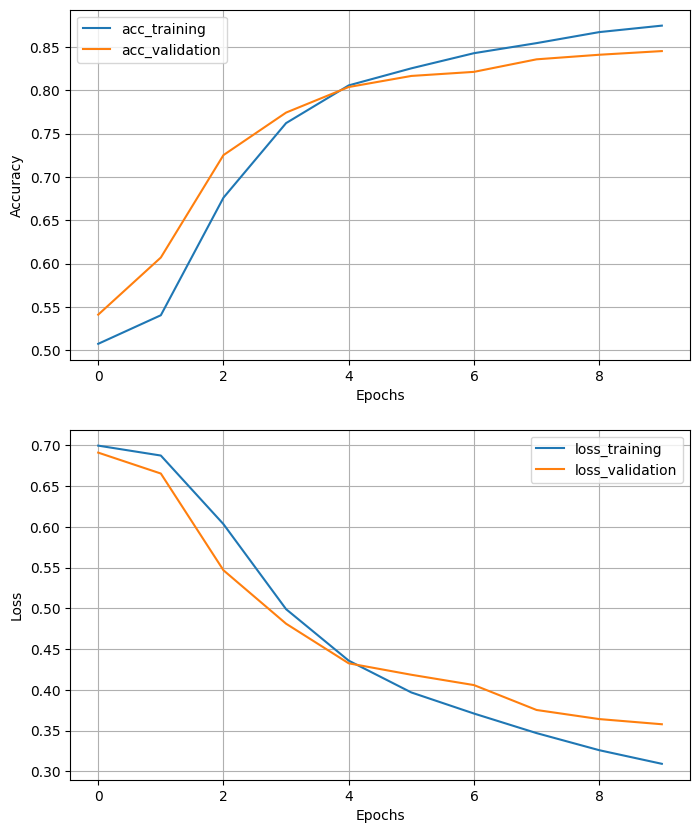

In [ ]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [ ]:
def test_trns(model, dataloader_test):
  model.eval()
  total_acc_test, total_count_test, n_batches_test, loss = 0, 0, 0, 0
  for idx, (label, text) in enumerate(dataloader_test):
      pre_label = model(text, label)
      loss += criterion(pre_label, label)
      labels_form_pre_label = lambda x: 0. if x < 0.5 else 1.
      pre_label = torch.tensor(list(map(labels_form_pre_label, pre_label))).to(model.device)
      total_acc_test += (pre_label == label).sum().item()
      total_count_test += label.size(0)
      n_batches_test += 1
  accuracy_test = total_acc_test/total_count_test
  loss_test = loss/n_batches_test
  print(f"Test Loss: {loss_test:.8f}", end=' ---------- ')
  print(f"Test Accuracy: {100*accuracy_test:.4f}%")

In [ ]:
gc.collect()
test_trns(transformer, dataloader_test_trns)

NameError: ignored